#### Importing the features required for prediction of patent class

In [40]:
import pandas as pd
features = pd.read_csv("./data/patent_class_features_after_2022_20230611.csv")
class_labels = pd.read_csv("./data/patent_class_after_2022_20230611.csv")
class_title_mapping = pd.read_csv("./data/class_title_mapping.csv")

In [41]:
features.head()

,PATENT,PUB_DATE,COUNTRY,PRIMARY_LANG,IPC,DWPI_TITLE,DWPI_DETAILED_DESCRIPTIONS,DWPI_NOVELTY,DWPI_USE
0,CN218280954U_,2023-01-13,CN,ZH_ZH,"['B01D004604', 'B01D004676', 'B01D004602', 'B0...",Surface anti-sticking dust-removing filter bag...,NaN,The utility model claims a surface anti-sticki...,NaN
1,CN218188237U_,2023-01-03,CN,ZH_ZH,"['B01D002996', 'B01D002933']",Environment-friendly reusable cooling liquid f...,NaN,The utility model claims a new environment-fri...,NaN
2,CN218442764U_,2023-02-03,CN,ZH_ZH,"['F24H000118', 'B08B000304', 'F24H000902', 'F2...",Organic silicon modified epoxy heat conducting...,NaN,The utility model claims an organic silicon mo...,NaN
3,CN218428090U_,2023-02-03,CN,ZH_ZH,['B25B002700'],"Electronic screen dismounting device, has lowe...",An INDEPENDENT CLAIM is included for the elect...,The utility model relates to screen disassembl...,NaN
4,CN218195410U_,2023-01-03,CN,ZH_ZH,"['B26D000702', 'B26D000510', 'B26D000108']","Inclined cutting paper cutting device, has cut...",NaN,The utility model claims an inclined cutting p...,NaN


In [42]:
class_labels.head()

,PATENT,CLASS
0,CN218280954U_,A88
1,CN218188237U_,A88
2,CN218442764U_,A88
3,CN218428090U_,A88
4,CN218195410U_,A88


In [43]:
class_title_mapping.head()

,Class,Title
0,A,Polymers & Plastics
1,B,Pharmaceuticals
2,C,Agricultural Chemicals
3,D,"Food, Fermentation, Disinfectants, Detergents"
4,E,General Chemicals


In [44]:
unique_class_codes = sorted(class_labels.CLASS.unique())
# Create a dictionary with keys as first letters and values as lists of codes
codes_dict = {}
for code in unique_class_codes:
    first_letter = code[0]
    if first_letter not in codes_dict:
        codes_dict[first_letter] = []
    codes_dict[first_letter].append(code)

# Display the lists for each letter
for letter, codes in codes_dict.items():
    print(f"{letter}: {codes}")

A: ['A11', 'A12', 'A13', 'A14', 'A17', 'A18', 'A21', 'A23', 'A25', 'A26', 'A28', 'A31', 'A32', 'A35', 'A41', 'A60', 'A81', 'A82', 'A83', 'A84', 'A85', 'A86', 'A87', 'A88', 'A89', 'A91', 'A92', 'A93', 'A94', 'A95', 'A96', 'A97']
B: ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07']
C: ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07']
D: ['D11', 'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D21', 'D22', 'D23', 'D24', 'D25']
E: ['E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E19', 'E21', 'E22', 'E23', 'E24', 'E31', 'E32', 'E33', 'E34', 'E35', 'E36', 'E37']
F: ['F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09']
G: ['G01', 'G02', 'G03', 'G04', 'G05', 'G06', 'G07', 'G08']
H: ['H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'H07', 'H08', 'H09']
J: ['J01', 'J02', 'J03', 'J04', 'J05', 'J06', 'J07', 'J08', 'J09']
K: ['K01', 'K02', 'K03', 'K04', 'K05', 'K06', 'K07', 'K08']
L: ['L01', 'L02', 'L03']
M: ['M11', 'M12', 'M13', 'M14', 'M21', 'M22', 'M23', 'M24', 'M25', 'M26', 'M27', 'M28', 

There are only IPC classes and sections under those classes. There are no subclasses and groups mentioned in class codes

In [45]:
# How many IPC sections are there ?
total_keys = len(codes_dict.keys())
print(total_keys)

20


This means I have to create 21 different classifiers. 1 for predicting the starting Alphabet/Class i.e., the root node of the tree. The top level

And then 1 classifier for each Alphabet/Class (20). So, total 21 different classifiers

In [46]:
# How many unique classes are there in each IPC section ?
for letter, codes in codes_dict.items():
    print(f"{letter}: {len(codes)}")

A: 32
B: 7
C: 7
D: 13
E: 19
F: 9
G: 8
H: 9
J: 9
K: 8
L: 3
M: 13
P: 46
Q: 54
S: 6
T: 7
U: 9
V: 8
W: 7
X: 13


In [47]:
features.shape

(344328, 9)

In [48]:
features.columns.dtype

dtype('O')

In [49]:
class_labels.shape

(461258, 2)

In [50]:
features.head()

,PATENT,PUB_DATE,COUNTRY,PRIMARY_LANG,IPC,DWPI_TITLE,DWPI_DETAILED_DESCRIPTIONS,DWPI_NOVELTY,DWPI_USE
0,CN218280954U_,2023-01-13,CN,ZH_ZH,"['B01D004604', 'B01D004676', 'B01D004602', 'B0...",Surface anti-sticking dust-removing filter bag...,NaN,The utility model claims a surface anti-sticki...,NaN
1,CN218188237U_,2023-01-03,CN,ZH_ZH,"['B01D002996', 'B01D002933']",Environment-friendly reusable cooling liquid f...,NaN,The utility model claims a new environment-fri...,NaN
2,CN218442764U_,2023-02-03,CN,ZH_ZH,"['F24H000118', 'B08B000304', 'F24H000902', 'F2...",Organic silicon modified epoxy heat conducting...,NaN,The utility model claims an organic silicon mo...,NaN
3,CN218428090U_,2023-02-03,CN,ZH_ZH,['B25B002700'],"Electronic screen dismounting device, has lowe...",An INDEPENDENT CLAIM is included for the elect...,The utility model relates to screen disassembl...,NaN
4,CN218195410U_,2023-01-03,CN,ZH_ZH,"['B26D000702', 'B26D000510', 'B26D000108']","Inclined cutting paper cutting device, has cut...",NaN,The utility model claims an inclined cutting p...,NaN


In [51]:
# PATENT, DWPI_TITLE and DWPI_NOVELTY are object data type, have to convert them to string
features['PATENT'] = features['PATENT'].astype(str).str.strip()
class_labels['PATENT'] = class_labels['PATENT'].astype(str).str.strip()
features['DWPI_TITLE'] = features['DWPI_TITLE'].astype(str).str.strip()
features['DWPI_NOVELTY'] = features['DWPI_NOVELTY'].astype(str).str.strip()

# Only first 2 characters of PRIMARY_LANG before delimeter "_" is required
def get_left_part(s):
    return s.split('_')[0]
features.PRIMARY_LANG = features.PRIMARY_LANG.apply(get_left_part)

# PUB_DATE column has to be parsed as pandas datetime object
features['PUB_DATE'] = pd.to_datetime(features['PUB_DATE'], format='%Y-%m-%d')
# Calculate the date range
start_date = features['PUB_DATE'].min()
end_date = features['PUB_DATE'].max()
# Print the date range
print(f"Date range: {start_date.date()} to {end_date.date()}")

Date range: 2023-01-01 to 2023-02-28


In [52]:
features.nunique()

PATENT                        344328
PUB_DATE                          59
COUNTRY                           40
PRIMARY_LANG                      23
IPC                           264953
DWPI_TITLE                    343353
DWPI_DETAILED_DESCRIPTIONS     85860
DWPI_NOVELTY                  343944
DWPI_USE                      147691
dtype: int64

In [53]:
missing_values_count = features.isna().sum()
print(missing_values_count)

PATENT                             0
PUB_DATE                           0
COUNTRY                            0
PRIMARY_LANG                       0
IPC                               15
DWPI_TITLE                         0
DWPI_DETAILED_DESCRIPTIONS    251364
DWPI_NOVELTY                       0
DWPI_USE                      193017
dtype: int64


In [54]:
# representing missing values as percentages (proportion)
# note IPC column still has 15 missing values
missing_values_count = round((features.isna().sum()/features.shape[0])*100,4)
print(missing_values_count)

PATENT                         0.0000
PUB_DATE                       0.0000
COUNTRY                        0.0000
PRIMARY_LANG                   0.0000
IPC                            0.0044
DWPI_TITLE                     0.0000
DWPI_DETAILED_DESCRIPTIONS    73.0013
DWPI_NOVELTY                   0.0000
DWPI_USE                      56.0561
dtype: float64


In [55]:
# Count duplicates for each column
duplicate_counts = {col: features[col].duplicated().sum() for col in features.columns}

# Display results in terms of %
for col, count in duplicate_counts.items():
    print(f"Column '{col}' has {round(count/features.shape[0]*100,2)}% duplicate values.")

Column 'PATENT' has 0.0% duplicate values.
Column 'PUB_DATE' has 99.98% duplicate values.
Column 'COUNTRY' has 99.99% duplicate values.
Column 'PRIMARY_LANG' has 99.99% duplicate values.
Column 'IPC' has 23.05% duplicate values.
Column 'DWPI_TITLE' has 0.28% duplicate values.
Column 'DWPI_DETAILED_DESCRIPTIONS' has 75.06% duplicate values.
Column 'DWPI_NOVELTY' has 0.11% duplicate values.
Column 'DWPI_USE' has 57.11% duplicate values.


**It means PATENT, IPC, DWPI_TITLE, DWPI_NOVELTY are significanlty important to differentiate between patents and maybe for even classification purposes.**

**Whereas DWPI_DETAILED_DESCRIPTIONS and DWPI_USE with a lot of duplicate and missing values seem insignificant. Dropping them makes sense.**

**Columns "PUB_DATE", "COUNTRY" and "PRIMARY_LANG" also seem insignificant for differentiating between patents and their respective classes.**

I have to calculate the word embeddings for DWPI_TITLE and DWPI_NOVELTY columns. One clever way can be to combine the text in both columns to make it a single column and then calculate the word embeddings. The way we calculate embeddings for a sentence is once we have embedding for each word in the sentence, we simply add the embeddings for every single word to get embeddings for the sentence. This will be the most important feature to predict classes

In [56]:
# Dropping insignificant columns
features = features.drop(columns=['DWPI_DETAILED_DESCRIPTIONS', 'DWPI_USE'])

In [57]:
class_labels.nunique()

PATENT    344328
CLASS        287
dtype: int64

#### There are 287 unique classes for 344328 unique patents. But the class_labels DataFrame has 344328 unique patents with 461258 rows which means that some patents belong to multiple classes

In [58]:
class_labels = class_labels.groupby('PATENT')['CLASS'].apply(list).reset_index()
class_labels

,PATENT,CLASS
0,AR123668A1,[Q31]
1,AR123669A1,"[T01, P14]"
2,AR123694A1,[Q49]
3,AR123695A1,"[S03, J04]"
4,AR123703A1,[A93]
...,...,...
344323,ZA202213920B_,[P14]
344324,ZA202300109B_,[Q43]
344325,ZA202300118B_,"[S05, T01]"
344326,ZA202300175B_,"[A96, D22, F07, P32]"


In [59]:
class_labels.shape

(344328, 2)

In [60]:
unmatched_in_features = features[~features['PATENT'].isin(class_labels['PATENT'])]
unmatched_in_class_labels = class_labels[~class_labels['PATENT'].isin(features['PATENT'])]

print("Patents in features but not in class_labels:", len(unmatched_in_features))
print("Patents in class_labels but not in features:", len(unmatched_in_class_labels))

Patents in features but not in class_labels: 0
Patents in class_labels but not in features: 0


In [61]:
#### There are 344328 unique patents in both the data frames with exact match so doing a inner join
df = features.merge(class_labels, on='PATENT', how='inner')
df.shape

(344328, 8)

In [62]:
# Which columns have missing values after the join ?
missing_values_count = df.isna().sum()
print(missing_values_count)

PATENT           0
PUB_DATE         0
COUNTRY          0
PRIMARY_LANG     0
IPC             15
DWPI_TITLE       0
DWPI_NOVELTY     0
CLASS            0
dtype: int64


In [63]:
# Dropping rows where IPC values are missing. It wouldn't hurt because these 15 rows account for only 0.0044% of entire dataset.
df = df.dropna(subset=['IPC'])
missing_values_count = df.isna().sum()
print(missing_values_count)
# Finally, no missing values. The dataset is still big enough for models to be trained upon. 

PATENT          0
PUB_DATE        0
COUNTRY         0
PRIMARY_LANG    0
IPC             0
DWPI_TITLE      0
DWPI_NOVELTY    0
CLASS           0
dtype: int64


In [64]:
# Just looking at some examples where Class has multiple values
df_multi_class = df[df['CLASS'].apply(lambda x: len(x) > 1)]
df_multi_class.head()

,PATENT,PUB_DATE,COUNTRY,PRIMARY_LANG,IPC,DWPI_TITLE,DWPI_NOVELTY,CLASS
52,CN218439434U_,2023-02-03,CN,ZH,"['E21F000500', 'B03C0003017']",Automatic cleaning screen for tunnel air purif...,The utility model claims an automatic cleaning...,"[J01, X25]"
240,FR3124913A1,2023-01-06,FR,FR,"['H04L00410816', 'H04L001200', 'H04L004500', '...",Method for managing orchestration entity in so...,The method involves obtaining (E70) an indicat...,"[T01, W01]"
241,CN218227814U_,2023-01-06,CN,ZH,"['B29C004956', 'B29C004942', 'B29C004964', 'B2...",nan,The machine has a pull plate device whose bott...,"[A92, A32]"
245,WO2023279108A1,2023-01-05,WO,EN,"['C12N001586', 'A61K004800', 'C07K001447']",New nucleic acid molecule comprising an adeno-...,"Nucleic acid molecule, comprising an adeno-ass...","[B04, D16]"
247,CN115584655A_,2023-01-10,CN,ZH,"['C05B000700', 'D21B000116', 'D21C000104', 'D2...",Utilizing wheat straw crushed by-product bio-f...,Utilizing wheat straw crushed by-product bio-f...,"[F09, C04]"


In [65]:
# IPC is a list of codes but the list is parsed as string. Converting the string to an actual list
df['IPC'] = df['IPC'].apply(eval)
# Stripping the IPC codes to limit it to just the first 3 characters only
def mask_IPC(x):
    return list(set([ipc[:3] for ipc in x]))
df.IPC = df.IPC.apply(mask_IPC)

In [66]:
# We can drop, PATENT, PUB_DATE, PRIMARY_LANG and COUNTRY column. 
# We need correlations to come to that conclusion
df.head()

,PATENT,PUB_DATE,COUNTRY,PRIMARY_LANG,IPC,DWPI_TITLE,DWPI_NOVELTY,CLASS
0,CN218280954U_,2023-01-13,CN,ZH,[B01],Surface anti-sticking dust-removing filter bag...,The utility model claims a surface anti-sticki...,[A88]
1,CN218188237U_,2023-01-03,CN,ZH,[B01],Environment-friendly reusable cooling liquid f...,The utility model claims a new environment-fri...,[A88]
2,CN218442764U_,2023-02-03,CN,ZH,"[B08, F24]",Organic silicon modified epoxy heat conducting...,The utility model claims an organic silicon mo...,[A88]
3,CN218428090U_,2023-02-03,CN,ZH,[B25],"Electronic screen dismounting device, has lowe...",The utility model relates to screen disassembl...,[A88]
4,CN218195410U_,2023-01-03,CN,ZH,[B26],"Inclined cutting paper cutting device, has cut...",The utility model claims an inclined cutting p...,[A88]


#### Finding Correlation between features and CLASS column.

1. PATENT is just a primary key as it is unique for every row, So, there will be no correlation
2. There is only 1 month of data so PUB_DATE is also not contributing to differentiate between classes. Insignificant

In [67]:
# One-hot encoding IPC and CLASS columns
ipc_encoded = df.explode('IPC')['IPC'].str.get_dummies().groupby(level=0).sum()
class_encoded = df.explode('CLASS')['CLASS'].str.get_dummies().groupby(level=0).sum()

# One-hot encode PRIMARY_LANG and COUNTRY
primary_lang_encoded = pd.get_dummies(df['PRIMARY_LANG'], prefix='LANG')
country_encoded = pd.get_dummies(df['COUNTRY'], prefix='COUNTRY')

# Calculate overall correlation
overall_correlation = ipc_encoded.corrwith(class_encoded, axis=0).mean()
print("Correlation between IPC and CLASS:", overall_correlation)

# Fill NaNs with 0 to avoid calculation issues
primary_lang_class_corr = primary_lang_encoded.corrwith(class_encoded, axis=0).fillna(0)
country_class_corr = country_encoded.corrwith(class_encoded, axis=0).fillna(0)

# Calculate the mean correlation for an overall value
overall_primary_lang_class_corr = primary_lang_class_corr.mean()
overall_country_class_corr = country_class_corr.mean()

print("Correlation between PRIMARY_LANG and CLASS:", overall_primary_lang_class_corr)
print("Correlation between COUNTRY and CLASS:", overall_country_class_corr)

Correlation between IPC and CLASS: -0.0002680179388479074
Correlation between PRIMARY_LANG and CLASS: 0.0
Correlation between COUNTRY and CLASS: 0.0


In [75]:
import plotly.express as px
import pandas as pd

# Extract unique main categories (first letter) and full codes
main_categories = []
subcategories = []

# Assuming df is defined with the 'CLASS' column
for classes in df['CLASS']:
    for cls_code in classes:
        main_categories.append(cls_code[0])  # First letter of each code
        subcategories.append(cls_code)         # Full code

# Strip any leading/trailing whitespace from the 'Class' column
class_title_mapping['Class'] = class_title_mapping['Class'].str.strip()

# Create the mapping dictionary without extra spaces
class_title_dict = {row['Class']: f"{row['Class']}: {row['Title']}" for _, row in class_title_mapping.iterrows()}

# Update each item in main_categories to include the title
for idx, char in enumerate(main_categories):
    main_categories[idx] = class_title_dict.get(char, char)  # Use dictionary to replace with "Class: Title" format

# Create a new DataFrame for the sunburst chart
sunburst_df = pd.DataFrame({
    'Main Category': main_categories,
    'Subcategory': subcategories
})

# Plot the sunburst chart
fig = px.sunburst(
    sunburst_df,
    path=['Main Category', 'Subcategory'],
    color_discrete_sequence=px.colors.qualitative.Pastel  # Color palette for clear differentiation
)

# Customize the layout with a centered title and enable legend
fig.update_layout(
    title=dict(
        text="Bifurcation of class codes up to the section level",  # Title text
        font=dict(size=20),  # Title font size
        x=0.5,  # Center the title
        xanchor='center'  # Anchor the title in the center
    ),
    margin=dict(t=50, l=0, r=0, b=0),  # Increase top margin for the title
    showlegend=True  # Enable legend
)

# Display the plot
fig.show()


In [69]:
import numpy as np
from itertools import combinations

# Strip to only the main class letters (first character) in each entry
df['category'] = df['CLASS'].apply(lambda classes: list(set(cls[0] for cls in classes)))

# Filter rows where there are multiple classes
df_multi_category = df[df['category'].apply(lambda x: len(x) > 1)]

# Get unique main classes
unique_classes = sorted(set([cls for sublist in df_multi_category['category'] for cls in sublist]))

# Initialize an empty co-occurrence matrix
cooccurrence_matrix = pd.DataFrame(0, index=unique_classes, columns=unique_classes)

# Populate the co-occurrence matrix
for classes in df_multi_category['category']:
    for (class1, class2) in combinations(classes, 2):
        cooccurrence_matrix.loc[class1, class2] += 1
        cooccurrence_matrix.loc[class2, class1] += 1  # Ensure symmetry

# Set the diagonal to zero
np.fill_diagonal(cooccurrence_matrix.values, 0)

# Display the co-occurrence matrix
cooccurrence_matrix.index = sorted(list(set(main_categories)))
cooccurrence_matrix.columns = sorted(list(set(main_categories)))
cooccurrence_matrix

,A: Polymers & Plastics,B: Pharmaceuticals,C: Agricultural Chemicals,"D: Food, Fermentation, Disinfectants, Detergents",E: General Chemicals,"F: Textiles, Paper, Cellulose","G: Printing, Coating, Photographic",H: Petroleum,J: Chemical Engineering,"K: Nucleonics, Explosives, Protection","L: Glass, Ceramics, Electro(in) Organics",M: Metallurgy,P: General,Q: Mechanical,"S: Instrumentation, Measuring and Testing",T: Computing and Control,U: Semiconductors and Electronic Circuitry,V: Electronic Components,W: Communications,X: Electric Power Engineering
A: Polymers & Plastics,0,1024,215,1698,782,1191,1484,273,668,40,1422,282,4403,3736,706,342,655,804,399,1557
B: Pharmaceuticals,1024,0,387,2077,48,45,18,3,233,32,13,18,1024,329,519,133,24,29,46,43
C: Agricultural Chemicals,215,387,0,545,35,18,13,13,88,3,8,3,551,42,45,19,5,6,13,7
"D: Food, Fermentation, Disinfectants, Detergents",1698,2077,545,0,519,376,93,90,473,16,56,45,1874,1061,487,188,38,90,79,247
E: General Chemicals,782,48,35,519,0,65,213,189,891,29,309,88,217,209,113,26,276,66,30,242
"F: Textiles, Paper, Cellulose",1191,45,18,376,65,0,101,18,71,4,74,20,823,507,54,50,11,46,26,154
"G: Printing, Coating, Photographic",1484,18,13,93,213,101,0,16,44,2,235,32,384,111,65,18,161,79,26,64
H: Petroleum,273,3,13,90,189,18,16,0,162,2,19,45,68,686,37,38,3,12,36,70
J: Chemical Engineering,668,233,88,473,891,71,44,162,0,15,97,118,1064,911,329,76,58,152,71,338
"K: Nucleonics, Explosives, Protection",40,32,3,16,29,4,2,2,15,0,8,11,28,71,19,13,4,10,9,44


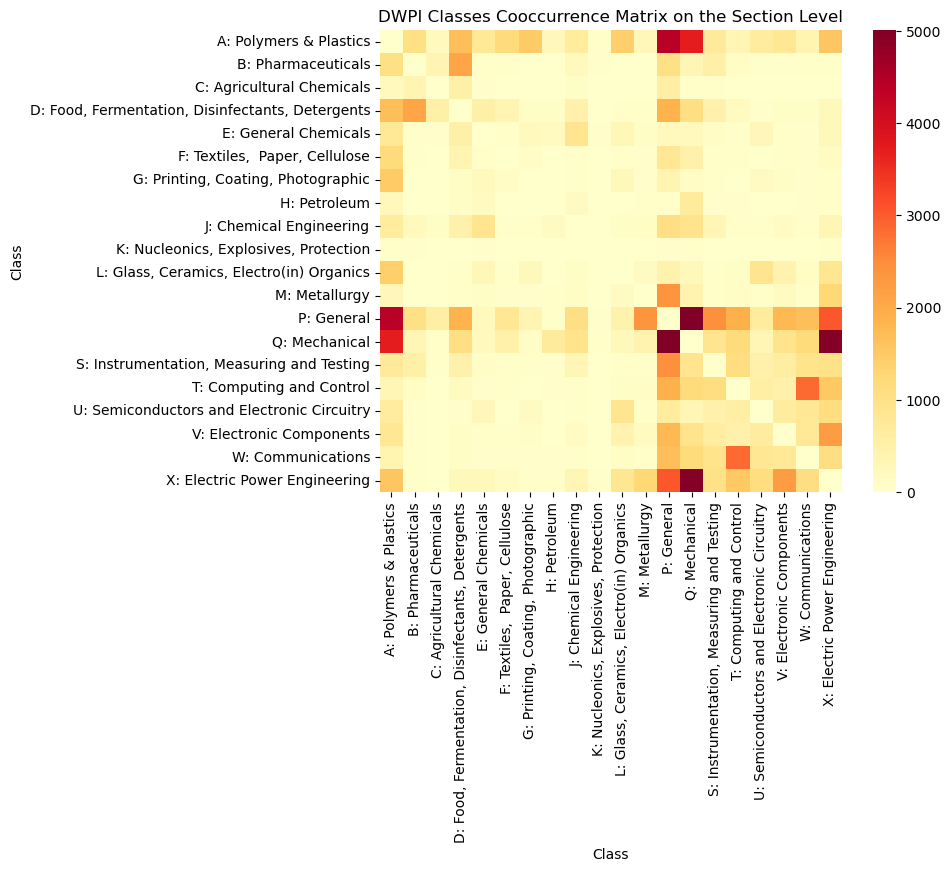

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `cooccurrence_matrix` is already created as shown in previous code
plt.figure(figsize=(8, 6))
sns.heatmap(cooccurrence_matrix, annot=False, cmap="YlOrRd", cbar=True, square=True)

# Customize the plot
plt.title("DWPI Classes Cooccurrence Matrix on the Section Level")
plt.xlabel("Class")
plt.ylabel("Class")
plt.show()

In [71]:
df_category_exploded = df.explode('category')

# Step 2: Count occurrences of each category
category_counts = df_category_exploded['category'].value_counts().reset_index()
category_counts.columns = ['category', 'Count']

sorted_unique_main_categories = sorted(list(set(main_categories)))

for idx in range(len(category_counts)):
    char = category_counts.at[idx, 'category'][0] # Get the first character
    for title in sorted_unique_main_categories:
        if char == title[0]:  # Check if the first character is in any of the titles
            category_counts.at[idx, 'category'] = title  # Replace with the full title
            
# Define 20 distinct colors for the bars
distinct_colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", 
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
    "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5"
]

# Step 3: Create a horizontal bar plot with distinct colors and a centered title
fig = px.bar(
    category_counts,
    x='Count',
    y='category',
    orientation='h',  # Horizontal bar plot
    title='Count of Patents Filed for Each Category',
    labels={'Count': 'Number of Patents', 'category': 'Patent Category'},
    color='category',  # Color each bar differently
    color_discrete_sequence=distinct_colors  # Use a custom color palette with 20 distinct colors
)

# Adjust layout
fig.update_layout(
    height=800,  # Increase height for more space
    yaxis=dict(tickmode='linear'),  # Ensure all labels show
    title={'x': 0.5},  # Center title
    showlegend=False  # Hide legend if not needed
)

# Show the plot
fig.show()

In [ ]:
# Make different dataframes for each class starting alphabet and plot alphabet count for each country
''' 
DWPI_TITLE and DWPI_NOVELTY columns can be combined into a single column and then embeddings can be generated for this combined column.
PATENT column doesnt seem to have any meaning because it is unique for each row. It seems like a primary key which is not important for classification.
Some patents have more than 1 Class/Alphabet associated with them such as [J01, X25]. 
The classifier at the top level needs to predict both J and X for this patent.
Then, I will send this patent to be further classified into the sections of J and X by using different classifiers trained for J and X respectively.
'''

' \nDWPI_TITLE and DWPI_NOVELTY columns can be combined into a single column and then embeddings can be generated for this combined column.\nPATENT column doesnt seem to have any meaning because it is unique for each row. It seems like a primary key which is not important for classification.\nSome patents have more than 1 Class/Alphabet associated with them such as [J01, X25]. \nThe classifier at the top level needs to predict both J and X for this patent.\nThen, I will send this patent to be further classified into the sections of J and X by using different classifiers trained for J and X respectively.\n'

In [87]:
# Just looking at some examples where Class has multiple values
data = df[df['category'].apply(lambda x: len(x) > 1)]
data[['DWPI_TITLE', 'DWPI_NOVELTY', 'category']]

,DWPI_TITLE,DWPI_NOVELTY,category
52,Automatic cleaning screen for tunnel air purif...,The utility model claims an automatic cleaning...,"[J, X]"
240,Method for managing orchestration entity in so...,The method involves obtaining (E70) an indicat...,"[W, T]"
245,New nucleic acid molecule comprising an adeno-...,"Nucleic acid molecule, comprising an adeno-ass...","[B, D]"
247,Utilizing wheat straw crushed by-product bio-f...,Utilizing wheat straw crushed by-product bio-f...,"[F, C]"
251,Game machine such as pachinko machine and slot...,The game machine (1) has a game frame and a ga...,"[W, T]"
...,...,...,...
343515,System for collecting data from multiple data ...,The system has a controller that determines a ...,"[W, T]"
343684,"Method for routing nodes in sensor network, in...",The method involves checking (S110) a table se...,"[W, T]"
343753,Learning content matching method for providing...,The method involves inputting learner informat...,"[W, T]"
343926,System for training feature encoder for encodi...,The system has a processor for determining a b...,"[W, T]"
